In [1]:
import torch
from tqdm import tqdm
from torch import nn, optim
from torch.nn import init
import pandas as pd
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

data = pd.read_csv("../../data2/data.csv").drop(columns = ["id", "source", 
                                                       "latitude", "longitude"])

In [2]:
class TabularFFNNSimple(nn.Module):
    def __init__(self, input_size, output_size, dropout_prob=0.4):
        super(TabularFFNNSimple, self).__init__()
        hidden_size = 64
        self.ffnn = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
#             nn.BatchNorm1d(hidden_size),
            nn.Dropout(0.1),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size, output_size)
        )
        
        for m in self.ffnn:
            if isinstance(m, nn.Linear):
                init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0)

    def forward(self, x):
        x = x.float()
        # print(x)
        x = x.view(x.size(0), -1)
        x = self.ffnn(x)
        return x
    
# Split the data into features and target
X = data.drop('price', axis=1)
y = data['price']

# Standardize the features
device = torch.device("cpu")
# Convert to PyTorch tensors
X_tensor = torch.tensor(X.to_numpy(), dtype=torch.float32, device = device)
y_tensor = torch.tensor(y.values, dtype=torch.float32, device = device)


# Split the data into training and combined validation and testing sets
X_train, X_val_test, y_train, y_val_test = train_test_split(X_tensor, y_tensor,
                                                            test_size=0.4, random_state=42)

# Split the combined validation and testing sets
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

# Create DataLoader for training, validation, and testing
train_data = TensorDataset(X_train, y_train)
val_data = TensorDataset(X_val, y_val)
test_data = TensorDataset(X_test, y_test)

batch_size = 256
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Check if the dimensions match the expected input size for the model
input_size = X_train.shape[1]

# Output
# input_size, train_loader, test_loader

model = TabularFFNNSimple(
    input_size = input_size,
    output_size = 1
)
model.to(device)

num_epochs = 300000
train_losses = []
val_losses = []
epochs_suc = [] # to have a reference to it
grad_norms = []

def get_gradient_norm(model):
    total_norm = 0
    for p in model.parameters():
        if p.grad is not None:
            param_norm = p.grad.data.norm(2)
            total_norm += param_norm.item() ** 2
    total_norm = total_norm ** 0.5
    return total_norm

In [3]:
optimizer = optim.Adam(
    model.parameters(), 
    lr=9e-3,
    weight_decay=1e-4
)
criterion = torch.nn.MSELoss()
criterion_abs = torch.nn.L1Loss()
criterion = criterion_abs

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=0.999999, 
    patience=5, 
    verbose=True
)

for epoch in range(num_epochs):
    # Training
    model.train()  # Set the model to training mode
    running_loss = 0.0
    l1_losses = []
    grad_norm = 0
    for tuple_ in train_loader:
        datas, prices = tuple_
        optimizer.zero_grad()
        outputs = model(datas)
        prices_viewed = prices.view(-1, 1).float()
        loss = criterion(outputs, prices_viewed)
        loss.backward()
        grad_norm += get_gradient_norm(model)
        optimizer.step()

        running_loss += loss.item()
        
    grad_norms.append(grad_norm / len(train_loader))
    train_losses.append(running_loss / len(train_loader))  # Average loss for this epoch

    # Validation
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():  # Disable gradient calculation
        for tuple_ in val_loader:
            datas, prices = tuple_
            outputs = model(datas)  # Forward pass
            prices_viewed = prices.view(-1, 1).float()
            loss = criterion(outputs, prices_viewed)  # Compute loss
            val_loss += loss.item()  # Accumulate the loss
            l1_losses.append(criterion_abs(outputs, prices_viewed))

    val_losses.append(val_loss / len(val_loader))  # Average loss for this epoch
    l1_mean_loss = sum(l1_losses) / len(l1_losses)
    # Print epoch's summary
    epochs_suc.append(epoch)
    scheduler.step(val_losses[-1])
    if epoch % 100 == 0:
        tl = f"Training Loss: {int(train_losses[-1])}"
        vl = f"Validation Loss: {int(val_losses[-1])}"
        l1 = f"L1: {int(l1_mean_loss)}"
        dl = f'Epoch {epoch+1}, {tl}, {vl}, {grad_norms[-1]}'
        print(dl)

Epoch 1, Training Loss: 230736, Validation Loss: 225692, 19371.189133565545
Epoch 101, Training Loss: 67212, Validation Loss: 65115, 70026.8113734025
Epoch 201, Training Loss: 62527, Validation Loss: 57177, 207634.27056806735
Epoch 301, Training Loss: 61059, Validation Loss: 58635, 270514.6441880083
Epoch 401, Training Loss: 56367, Validation Loss: 54806, 183101.93715866373
Epoch 501, Training Loss: 55409, Validation Loss: 54445, 202596.1800139094
Epoch 601, Training Loss: 53169, Validation Loss: 53696, 163139.04122935576
Epoch 701, Training Loss: 55917, Validation Loss: 59549, 227824.1912576616
Epoch 801, Training Loss: 51337, Validation Loss: 52265, 175816.96591024828
Epoch 901, Training Loss: 53174, Validation Loss: 50838, 184761.95120466087
Epoch 1001, Training Loss: 50331, Validation Loss: 52518, 160121.75680060982
Epoch 1101, Training Loss: 52326, Validation Loss: 51275, 210400.9281382421
Epoch 1201, Training Loss: 50204, Validation Loss: 50022, 162976.73072395526
Epoch 1301, Tra

Epoch 10701, Training Loss: 42801, Validation Loss: 48305, 234718.21013679882
Epoch 10801, Training Loss: 42598, Validation Loss: 48647, 212113.01640916493
Epoch 10901, Training Loss: 43044, Validation Loss: 47061, 162461.85865630332
Epoch 11001, Training Loss: 43525, Validation Loss: 47148, 226463.10818906347
Epoch 11101, Training Loss: 42767, Validation Loss: 47989, 265387.82284088753
Epoch 11201, Training Loss: 42766, Validation Loss: 46528, 189016.6977162146
Epoch 11301, Training Loss: 40362, Validation Loss: 47489, 184881.8865567253
Epoch 11401, Training Loss: 40015, Validation Loss: 50748, 202757.30455332817
Epoch 11501, Training Loss: 42698, Validation Loss: 47399, 261187.98224435732
Epoch 11601, Training Loss: 43187, Validation Loss: 48022, 297730.02481382777
Epoch 11701, Training Loss: 40036, Validation Loss: 47085, 157341.45460652845
Epoch 11801, Training Loss: 42512, Validation Loss: 49529, 183813.6816338934
Epoch 11901, Training Loss: 43449, Validation Loss: 51218, 249046.8

Epoch 21301, Training Loss: 36921, Validation Loss: 48466, 155698.4815156714
Epoch 21401, Training Loss: 38829, Validation Loss: 48422, 158750.5767319329
Epoch 21501, Training Loss: 38321, Validation Loss: 45796, 195561.165235524
Epoch 21601, Training Loss: 39108, Validation Loss: 46810, 245672.3920987829
Epoch 21701, Training Loss: 38135, Validation Loss: 48022, 180692.0871357278
Epoch 21801, Training Loss: 37850, Validation Loss: 50412, 249558.9757838807
Epoch 21901, Training Loss: 39110, Validation Loss: 46696, 213000.6706742379
Epoch 22001, Training Loss: 35403, Validation Loss: 47364, 182303.63036908623
Epoch 22101, Training Loss: 38145, Validation Loss: 48269, 178233.27094000304
Epoch 22201, Training Loss: 37631, Validation Loss: 45799, 151620.31677556835
Epoch 22301, Training Loss: 36273, Validation Loss: 51091, 225697.3985339425
Epoch 22401, Training Loss: 40794, Validation Loss: 45990, 203612.97812654174
Epoch 22501, Training Loss: 38761, Validation Loss: 48188, 191825.7726542

Epoch 31901, Training Loss: 36518, Validation Loss: 47928, 178128.6523636084
Epoch 32001, Training Loss: 38010, Validation Loss: 52108, 248350.55282867188
Epoch 32101, Training Loss: 36776, Validation Loss: 48954, 171532.47359580584
Epoch 32201, Training Loss: 35499, Validation Loss: 47323, 243195.48622529604
Epoch 32301, Training Loss: 35963, Validation Loss: 49342, 181387.62526868525
Epoch 32401, Training Loss: 35104, Validation Loss: 47462, 174308.82183638276
Epoch 32501, Training Loss: 36201, Validation Loss: 47058, 171646.8791167444
Epoch 32601, Training Loss: 37006, Validation Loss: 46813, 155401.0245834302
Epoch 32701, Training Loss: 37149, Validation Loss: 47177, 167871.6232418012
Epoch 32801, Training Loss: 36699, Validation Loss: 48499, 182880.28658559997
Epoch 32901, Training Loss: 35250, Validation Loss: 51650, 167472.99106420172
Epoch 33001, Training Loss: 38158, Validation Loss: 47479, 189010.5169048269
Epoch 33101, Training Loss: 37683, Validation Loss: 50206, 223534.190

Epoch 42501, Training Loss: 34079, Validation Loss: 48927, 142818.81138279528
Epoch 42601, Training Loss: 36139, Validation Loss: 48177, 160374.21196130474
Epoch 42701, Training Loss: 33859, Validation Loss: 48842, 201690.35683040167
Epoch 42801, Training Loss: 35689, Validation Loss: 47507, 206507.6467519372
Epoch 42901, Training Loss: 32914, Validation Loss: 51910, 166584.25252658865
Epoch 43001, Training Loss: 34222, Validation Loss: 48595, 198996.8294189878
Epoch 43101, Training Loss: 35475, Validation Loss: 49768, 198596.81854036817
Epoch 43201, Training Loss: 36464, Validation Loss: 50271, 214518.75180510897
Epoch 43301, Training Loss: 33737, Validation Loss: 51642, 172814.17847997946
Epoch 43401, Training Loss: 34646, Validation Loss: 50186, 136046.40981319683
Epoch 43501, Training Loss: 33668, Validation Loss: 52009, 159146.48019874512
Epoch 43601, Training Loss: 33230, Validation Loss: 47807, 147922.03980703995
Epoch 43701, Training Loss: 34315, Validation Loss: 49249, 165057.

Epoch 53101, Training Loss: 33802, Validation Loss: 51373, 147120.73762528092
Epoch 53201, Training Loss: 34140, Validation Loss: 51610, 158135.19213974668
Epoch 53301, Training Loss: 33116, Validation Loss: 52402, 135671.81228436955
Epoch 53401, Training Loss: 33219, Validation Loss: 51591, 164135.3036070006
Epoch 53501, Training Loss: 33669, Validation Loss: 49846, 131314.75512940943
Epoch 53601, Training Loss: 35350, Validation Loss: 53842, 148167.96108678877
Epoch 53701, Training Loss: 33144, Validation Loss: 49716, 158157.17003683012
Epoch 53801, Training Loss: 30474, Validation Loss: 54193, 160341.08968067664
Epoch 53901, Training Loss: 33939, Validation Loss: 49641, 137617.4054469911
Epoch 54001, Training Loss: 34384, Validation Loss: 53341, 155194.98897147103
Epoch 54101, Training Loss: 35938, Validation Loss: 48993, 183184.73450646596
Epoch 54201, Training Loss: 33504, Validation Loss: 51057, 142476.7143587282
Epoch 54301, Training Loss: 31950, Validation Loss: 49991, 156597.4

Epoch 63701, Training Loss: 33313, Validation Loss: 52412, 146021.1912587088
Epoch 63801, Training Loss: 33963, Validation Loss: 50105, 128001.10597934667
Epoch 63901, Training Loss: 32861, Validation Loss: 50056, 139984.21529803867
Epoch 64001, Training Loss: 33187, Validation Loss: 51537, 184823.5703610128
Epoch 64101, Training Loss: 32083, Validation Loss: 53084, 150448.3584210595
Epoch 64201, Training Loss: 32113, Validation Loss: 50739, 145390.45541679763
Epoch 64301, Training Loss: 33809, Validation Loss: 52472, 181871.16481139336
Epoch 64401, Training Loss: 32639, Validation Loss: 50338, 131669.7793199067
Epoch 64501, Training Loss: 31701, Validation Loss: 52656, 144642.62714535242
Epoch 64601, Training Loss: 32715, Validation Loss: 53738, 160576.07717117347
Epoch 64701, Training Loss: 32068, Validation Loss: 51172, 153107.54943612654
Epoch 64801, Training Loss: 33669, Validation Loss: 52494, 165056.2342437982
Epoch 64901, Training Loss: 32605, Validation Loss: 52191, 191104.193

Epoch 74301, Training Loss: 32065, Validation Loss: 52185, 150590.0803769656
Epoch 74401, Training Loss: 31485, Validation Loss: 52324, 131205.2609913147
Epoch 74501, Training Loss: 31478, Validation Loss: 53411, 182918.5912035278
Epoch 74601, Training Loss: 35329, Validation Loss: 54191, 237532.285657476
Epoch 74701, Training Loss: 32663, Validation Loss: 51046, 185448.8138605556
Epoch 74801, Training Loss: 31370, Validation Loss: 54666, 140721.08387989324
Epoch 74901, Training Loss: 32080, Validation Loss: 50435, 153396.0978389814
Epoch 75001, Training Loss: 33630, Validation Loss: 52605, 153109.1399270321
Epoch 75101, Training Loss: 30534, Validation Loss: 52254, 142881.47112354552
Epoch 75201, Training Loss: 33355, Validation Loss: 50015, 125587.19308520874
Epoch 75301, Training Loss: 31355, Validation Loss: 51283, 156399.95150262516
Epoch 75401, Training Loss: 32902, Validation Loss: 52326, 148505.85644177167
Epoch 75501, Training Loss: 32136, Validation Loss: 50073, 138810.727785

Epoch 84901, Training Loss: 31948, Validation Loss: 48731, 152706.66361101755
Epoch 85001, Training Loss: 31316, Validation Loss: 51480, 152741.9011628359
Epoch 85101, Training Loss: 32223, Validation Loss: 50591, 139995.7107492456
Epoch 85201, Training Loss: 30868, Validation Loss: 52096, 146773.5556713338
Epoch 85301, Training Loss: 31055, Validation Loss: 52824, 135261.6725110883
Epoch 85401, Training Loss: 32068, Validation Loss: 49606, 139769.77997263643
Epoch 85501, Training Loss: 32234, Validation Loss: 53312, 156149.1514790379
Epoch 85601, Training Loss: 31978, Validation Loss: 52360, 163177.76341409684
Epoch 85701, Training Loss: 32170, Validation Loss: 52204, 146413.1989415758
Epoch 85801, Training Loss: 30940, Validation Loss: 49338, 124416.44693623681
Epoch 85901, Training Loss: 32783, Validation Loss: 52135, 174730.54279553035
Epoch 86001, Training Loss: 30104, Validation Loss: 51809, 118637.95770356509
Epoch 86101, Training Loss: 34430, Validation Loss: 51694, 173354.8212

Epoch 95501, Training Loss: 30378, Validation Loss: 53260, 135574.3597107656
Epoch 95601, Training Loss: 31718, Validation Loss: 52000, 140306.97918874669
Epoch 95701, Training Loss: 30160, Validation Loss: 53364, 142847.39436308743
Epoch 95801, Training Loss: 32122, Validation Loss: 50666, 176674.3501751932
Epoch 95901, Training Loss: 33517, Validation Loss: 54140, 169429.93395415234
Epoch 96001, Training Loss: 31980, Validation Loss: 50330, 165320.22891741042
Epoch 96101, Training Loss: 31574, Validation Loss: 51865, 136754.72670149757
Epoch 96201, Training Loss: 31455, Validation Loss: 53141, 148979.76433422725
Epoch 96301, Training Loss: 32748, Validation Loss: 53342, 138248.55016798663
Epoch 96401, Training Loss: 31702, Validation Loss: 51467, 197371.04324477626
Epoch 96501, Training Loss: 32285, Validation Loss: 52270, 123605.4969012707
Epoch 96601, Training Loss: 31374, Validation Loss: 52917, 175345.13003774793
Epoch 96701, Training Loss: 32797, Validation Loss: 52335, 142786.7

Epoch 106001, Training Loss: 31454, Validation Loss: 51544, 152032.6010142792
Epoch 106101, Training Loss: 32617, Validation Loss: 52406, 131940.4633030273
Epoch 106201, Training Loss: 31729, Validation Loss: 51603, 158995.35006577737
Epoch 106301, Training Loss: 31051, Validation Loss: 49973, 134157.42795973393
Epoch 106401, Training Loss: 32336, Validation Loss: 50877, 174711.76280677697
Epoch 106501, Training Loss: 32022, Validation Loss: 52608, 125086.9840731237
Epoch 106601, Training Loss: 31043, Validation Loss: 52175, 146323.3771307456
Epoch 106701, Training Loss: 31196, Validation Loss: 51442, 122597.886259986
Epoch 106801, Training Loss: 32769, Validation Loss: 51504, 172771.30996549092
Epoch 106901, Training Loss: 32100, Validation Loss: 52591, 171043.47042516756
Epoch 107001, Training Loss: 31751, Validation Loss: 52553, 142322.3887985452
Epoch 107101, Training Loss: 32117, Validation Loss: 51460, 146450.27889787348
Epoch 107201, Training Loss: 31552, Validation Loss: 53403,

Epoch 116501, Training Loss: 31188, Validation Loss: 51926, 114995.88541767592
Epoch 116601, Training Loss: 31605, Validation Loss: 51201, 149857.48950940697
Epoch 116701, Training Loss: 32035, Validation Loss: 51160, 140685.6825718923
Epoch 116801, Training Loss: 31621, Validation Loss: 52072, 142158.86393555408
Epoch 116901, Training Loss: 30590, Validation Loss: 52741, 177311.7964770468
Epoch 117001, Training Loss: 30927, Validation Loss: 53370, 143339.25712358113
Epoch 117101, Training Loss: 31169, Validation Loss: 53397, 123161.83414343838
Epoch 117201, Training Loss: 33090, Validation Loss: 52456, 150806.21069094897
Epoch 117301, Training Loss: 32695, Validation Loss: 55213, 146260.79970141884
Epoch 117401, Training Loss: 31423, Validation Loss: 54953, 166313.13460389816
Epoch 117501, Training Loss: 31238, Validation Loss: 53687, 133693.53536126998
Epoch 117601, Training Loss: 30026, Validation Loss: 53659, 176633.57495417402
Epoch 117701, Training Loss: 31405, Validation Loss: 5

Epoch 127001, Training Loss: 31361, Validation Loss: 52634, 188381.4218406352
Epoch 127101, Training Loss: 29874, Validation Loss: 53165, 145242.7896565393
Epoch 127201, Training Loss: 32429, Validation Loss: 52581, 136281.09289246835
Epoch 127301, Training Loss: 31190, Validation Loss: 52372, 135161.1098115302
Epoch 127401, Training Loss: 31415, Validation Loss: 52183, 141789.50818634024
Epoch 127501, Training Loss: 32011, Validation Loss: 55578, 146245.8813645429
Epoch 127601, Training Loss: 29992, Validation Loss: 54928, 154358.1602506766
Epoch 127701, Training Loss: 30053, Validation Loss: 53721, 157629.19888536018
Epoch 127801, Training Loss: 30676, Validation Loss: 53586, 165900.074969945
Epoch 127901, Training Loss: 31527, Validation Loss: 53869, 164297.7369281279
Epoch 128001, Training Loss: 31778, Validation Loss: 52232, 145302.66641237322
Epoch 128101, Training Loss: 30565, Validation Loss: 52167, 151495.81993414284
Epoch 128201, Training Loss: 32257, Validation Loss: 54138, 

Epoch 137501, Training Loss: 28456, Validation Loss: 52586, 172745.52684672351
Epoch 137601, Training Loss: 32572, Validation Loss: 51756, 161730.93862060033
Epoch 137701, Training Loss: 31470, Validation Loss: 54796, 183354.80247238086
Epoch 137801, Training Loss: 30423, Validation Loss: 53214, 141446.15690378263
Epoch 137901, Training Loss: 30914, Validation Loss: 50566, 163473.11304273093
Epoch 138001, Training Loss: 29296, Validation Loss: 54820, 152413.76854266395
Epoch 138101, Training Loss: 30483, Validation Loss: 52579, 133681.25738903836
Epoch 138201, Training Loss: 31608, Validation Loss: 52043, 166838.1791308301
Epoch 138301, Training Loss: 30200, Validation Loss: 54763, 131100.05334093474
Epoch 138401, Training Loss: 30621, Validation Loss: 52078, 168045.87996362973
Epoch 138501, Training Loss: 32525, Validation Loss: 52019, 129251.9281902042
Epoch 138601, Training Loss: 31335, Validation Loss: 53360, 167896.32843466586
Epoch 138701, Training Loss: 31111, Validation Loss: 5

Epoch 148001, Training Loss: 31724, Validation Loss: 51883, 156153.73282274202
Epoch 148101, Training Loss: 30217, Validation Loss: 53824, 125229.11634648297
Epoch 148201, Training Loss: 30964, Validation Loss: 53160, 139342.33955059687
Epoch 148301, Training Loss: 30451, Validation Loss: 55670, 143695.56400071312
Epoch 148401, Training Loss: 30172, Validation Loss: 54017, 169935.33892327923
Epoch 148501, Training Loss: 29409, Validation Loss: 55419, 165600.6641655962
Epoch 148601, Training Loss: 29557, Validation Loss: 54882, 154369.0675647423
Epoch 148701, Training Loss: 31457, Validation Loss: 55821, 148344.06592329472
Epoch 148801, Training Loss: 31433, Validation Loss: 53500, 129196.25427791472
Epoch 148901, Training Loss: 31546, Validation Loss: 52130, 141467.8073153848
Epoch 149001, Training Loss: 30012, Validation Loss: 52952, 131438.58142714654
Epoch 149101, Training Loss: 29804, Validation Loss: 53617, 120243.22303335876
Epoch 149201, Training Loss: 30525, Validation Loss: 53

Epoch 158501, Training Loss: 31329, Validation Loss: 51872, 157619.9010729148
Epoch 158601, Training Loss: 31585, Validation Loss: 51223, 170830.6219371984
Epoch 158701, Training Loss: 31543, Validation Loss: 54471, 159932.97344864477
Epoch 158801, Training Loss: 30993, Validation Loss: 54047, 136972.66819308797
Epoch 158901, Training Loss: 29034, Validation Loss: 53147, 143377.10323352378
Epoch 159001, Training Loss: 30624, Validation Loss: 53547, 173301.4582936042
Epoch 159101, Training Loss: 30742, Validation Loss: 51347, 157634.4950815243
Epoch 159201, Training Loss: 28638, Validation Loss: 53833, 137669.76078009943
Epoch 159301, Training Loss: 30837, Validation Loss: 54863, 152287.52324509376
Epoch 159401, Training Loss: 31667, Validation Loss: 52954, 159156.5583611047
Epoch 159501, Training Loss: 30246, Validation Loss: 52179, 157629.6156954974
Epoch 159601, Training Loss: 31204, Validation Loss: 52566, 147473.26262215612
Epoch 159701, Training Loss: 30857, Validation Loss: 52290

Epoch 169001, Training Loss: 31196, Validation Loss: 55638, 122484.36055369212
Epoch 169101, Training Loss: 31966, Validation Loss: 52631, 142575.77326900093
Epoch 169201, Training Loss: 31921, Validation Loss: 53879, 168120.67751433916
Epoch 169301, Training Loss: 31400, Validation Loss: 54466, 173351.78009375217
Epoch 169401, Training Loss: 30778, Validation Loss: 55081, 110848.53754983936
Epoch 169501, Training Loss: 31454, Validation Loss: 54730, 166128.3339137155
Epoch 169601, Training Loss: 31758, Validation Loss: 53420, 148868.4475099261
Epoch 169701, Training Loss: 31342, Validation Loss: 56040, 182526.18900381745
Epoch 169801, Training Loss: 31949, Validation Loss: 54168, 157763.9069991865
Epoch 169901, Training Loss: 30471, Validation Loss: 54671, 131874.12208276583
Epoch 170001, Training Loss: 29792, Validation Loss: 54837, 127383.10259350669
Epoch 170101, Training Loss: 30118, Validation Loss: 53429, 158409.39324327558
Epoch 170201, Training Loss: 30568, Validation Loss: 55

Epoch 179401, Training Loss: 30521, Validation Loss: 54075, 145860.0517247324
Epoch 179501, Training Loss: 30120, Validation Loss: 52870, 143337.2327691925
Epoch 179601, Training Loss: 31332, Validation Loss: 54453, 165935.01792224814
Epoch 179701, Training Loss: 30889, Validation Loss: 56769, 115906.63482915107
Epoch 179801, Training Loss: 29005, Validation Loss: 54439, 143850.46766624664
Epoch 179901, Training Loss: 30862, Validation Loss: 55231, 133030.40491416096
Epoch 180001, Training Loss: 31856, Validation Loss: 52873, 132642.53211019124
Epoch 180101, Training Loss: 34127, Validation Loss: 54754, 160594.60305185313
Epoch 180201, Training Loss: 30906, Validation Loss: 53535, 147948.9394905527
Epoch 180301, Training Loss: 32389, Validation Loss: 54811, 143012.42097292253
Epoch 180401, Training Loss: 30741, Validation Loss: 53132, 144803.4622073383
Epoch 180501, Training Loss: 30972, Validation Loss: 55096, 147727.91827341792
Epoch 180601, Training Loss: 31397, Validation Loss: 535

Epoch 189901, Training Loss: 28404, Validation Loss: 55383, 148092.23215367866
Epoch 190001, Training Loss: 29979, Validation Loss: 56708, 158518.64240647206
Epoch 190101, Training Loss: 30427, Validation Loss: 55538, 182075.3425825575
Epoch 190201, Training Loss: 32101, Validation Loss: 53140, 178156.85512937064
Epoch 190301, Training Loss: 30081, Validation Loss: 55518, 125674.52554965124
Epoch 190401, Training Loss: 31496, Validation Loss: 55924, 164996.22337374635
Epoch 190501, Training Loss: 28510, Validation Loss: 54384, 144754.0825872438
Epoch 190601, Training Loss: 30292, Validation Loss: 53473, 150307.19194852564
Epoch 190701, Training Loss: 31060, Validation Loss: 55902, 144724.27925503434
Epoch 190801, Training Loss: 31209, Validation Loss: 54085, 172155.61773520155
Epoch 190901, Training Loss: 29762, Validation Loss: 52889, 157192.83063566522
Epoch 191001, Training Loss: 30089, Validation Loss: 54100, 170587.86977187064
Epoch 191101, Training Loss: 31675, Validation Loss: 5

Epoch 200401, Training Loss: 31036, Validation Loss: 55221, 131042.87809697053
Epoch 200501, Training Loss: 30163, Validation Loss: 54270, 130771.16414908537
Epoch 200601, Training Loss: 30306, Validation Loss: 54251, 154622.06002142705
Epoch 200701, Training Loss: 30975, Validation Loss: 53776, 152282.3141660283
Epoch 200801, Training Loss: 32548, Validation Loss: 57553, 142783.51561705777
Epoch 200901, Training Loss: 31130, Validation Loss: 54296, 124315.1165399022
Epoch 201001, Training Loss: 31454, Validation Loss: 56228, 183932.86279281325
Epoch 201101, Training Loss: 29704, Validation Loss: 54855, 152716.03303173
Epoch 201201, Training Loss: 29720, Validation Loss: 56525, 132414.4387802317
Epoch 201301, Training Loss: 29479, Validation Loss: 52946, 152374.94759110818
Epoch 201401, Training Loss: 30368, Validation Loss: 51613, 156137.49027224077
Epoch 201501, Training Loss: 29693, Validation Loss: 53489, 125534.69725044779
Epoch 201601, Training Loss: 28888, Validation Loss: 53455

Epoch 210901, Training Loss: 29918, Validation Loss: 55394, 124472.43068122848
Epoch 211001, Training Loss: 30182, Validation Loss: 55904, 165675.49123301194
Epoch 211101, Training Loss: 31867, Validation Loss: 54479, 150856.8179866039
Epoch 211201, Training Loss: 31156, Validation Loss: 55028, 131276.22735339636
Epoch 211301, Training Loss: 32090, Validation Loss: 55081, 115778.57313900266
Epoch 211401, Training Loss: 32008, Validation Loss: 51851, 144664.80105031782
Epoch 211501, Training Loss: 30021, Validation Loss: 53071, 129071.54417349333
Epoch 211601, Training Loss: 32396, Validation Loss: 54484, 165942.83708784982
Epoch 211701, Training Loss: 32332, Validation Loss: 56635, 147359.86571288473
Epoch 211801, Training Loss: 31963, Validation Loss: 53619, 152681.70328936045
Epoch 211901, Training Loss: 30034, Validation Loss: 53177, 153848.0815590368
Epoch 212001, Training Loss: 30828, Validation Loss: 54971, 153931.43553674052
Epoch 212101, Training Loss: 30231, Validation Loss: 5

Epoch 221401, Training Loss: 29505, Validation Loss: 54774, 145166.99339448762
Epoch 221501, Training Loss: 30184, Validation Loss: 53259, 137480.78342453396
Epoch 221601, Training Loss: 30332, Validation Loss: 57200, 154667.52631622215
Epoch 221701, Training Loss: 29387, Validation Loss: 55274, 153099.28944952073
Epoch 221801, Training Loss: 29068, Validation Loss: 53413, 143469.11278415233
Epoch 221901, Training Loss: 30743, Validation Loss: 57888, 170905.48098987932
Epoch 222001, Training Loss: 31779, Validation Loss: 54219, 175033.2009250818
Epoch 222101, Training Loss: 29746, Validation Loss: 54288, 133525.63942955434
Epoch 222201, Training Loss: 29528, Validation Loss: 55453, 132995.528416651
Epoch 222301, Training Loss: 30193, Validation Loss: 56370, 140491.69999800948
Epoch 222401, Training Loss: 31507, Validation Loss: 53566, 149855.2831232348
Epoch 222501, Training Loss: 30532, Validation Loss: 53098, 126140.60309487963
Epoch 222601, Training Loss: 31186, Validation Loss: 536

Epoch 231901, Training Loss: 28900, Validation Loss: 55967, 142501.36763019938
Epoch 232001, Training Loss: 29970, Validation Loss: 55392, 159769.69228964893
Epoch 232101, Training Loss: 29386, Validation Loss: 55541, 112229.13915167484
Epoch 232201, Training Loss: 29387, Validation Loss: 55795, 141037.69173231133
Epoch 232301, Training Loss: 30023, Validation Loss: 54944, 122786.41015201197
Epoch 232401, Training Loss: 29906, Validation Loss: 54648, 146168.90896394104
Epoch 232501, Training Loss: 29994, Validation Loss: 55975, 155010.27821219378
Epoch 232601, Training Loss: 32133, Validation Loss: 56846, 177970.9483420881
Epoch 232701, Training Loss: 30004, Validation Loss: 55656, 185870.80425194907
Epoch 232801, Training Loss: 29317, Validation Loss: 55141, 138533.63217760128
Epoch 232901, Training Loss: 30272, Validation Loss: 53019, 147463.05059995083
Epoch 233001, Training Loss: 30624, Validation Loss: 57889, 163389.2585643484
Epoch 233101, Training Loss: 30387, Validation Loss: 5

Epoch 242401, Training Loss: 30753, Validation Loss: 53997, 147515.96125573703
Epoch 242501, Training Loss: 32078, Validation Loss: 53822, 149036.88598167343
Epoch 242601, Training Loss: 30897, Validation Loss: 54201, 153977.6695117619
Epoch 242701, Training Loss: 30887, Validation Loss: 55455, 125398.8128250388
Epoch 242801, Training Loss: 30159, Validation Loss: 56067, 149114.62194190075
Epoch 242901, Training Loss: 29954, Validation Loss: 56078, 138605.19056329384
Epoch 243001, Training Loss: 30604, Validation Loss: 56424, 161387.6511073055
Epoch 243101, Training Loss: 30081, Validation Loss: 53447, 138568.2143068332
Epoch 243201, Training Loss: 30627, Validation Loss: 53221, 164857.2683593538
Epoch 243301, Training Loss: 30459, Validation Loss: 54213, 128216.5847318165
Epoch 243401, Training Loss: 30584, Validation Loss: 54359, 145424.87461571404
Epoch 243501, Training Loss: 30787, Validation Loss: 55923, 156086.6462174809
Epoch 243601, Training Loss: 29948, Validation Loss: 54007,

Epoch 252901, Training Loss: 28933, Validation Loss: 54670, 127230.27012040773
Epoch 253001, Training Loss: 30328, Validation Loss: 55846, 159039.53704480434
Epoch 253101, Training Loss: 31758, Validation Loss: 56718, 143142.48455961497
Epoch 253201, Training Loss: 31375, Validation Loss: 56400, 175525.8674203835
Epoch 253301, Training Loss: 28799, Validation Loss: 54149, 140392.9445726807
Epoch 253401, Training Loss: 28874, Validation Loss: 55440, 144805.38658522948
Epoch 253501, Training Loss: 29494, Validation Loss: 55041, 133157.59088325995
Epoch 253601, Training Loss: 28997, Validation Loss: 57853, 149867.22449459057
Epoch 253701, Training Loss: 29153, Validation Loss: 54806, 152836.3829504698
Epoch 253801, Training Loss: 29452, Validation Loss: 51757, 134296.60802009428
Epoch 253901, Training Loss: 30383, Validation Loss: 56984, 157707.2574208356
Epoch 254001, Training Loss: 30506, Validation Loss: 54431, 145634.7606839587
Epoch 254101, Training Loss: 29419, Validation Loss: 5561

Epoch 263401, Training Loss: 29692, Validation Loss: 56435, 156816.23722802772
Epoch 263501, Training Loss: 32306, Validation Loss: 54253, 159277.20115153491
Epoch 263601, Training Loss: 29001, Validation Loss: 54156, 149202.86997888298
Epoch 263701, Training Loss: 30140, Validation Loss: 53413, 148657.26800971848
Epoch 263801, Training Loss: 31242, Validation Loss: 55929, 153200.75924480107
Epoch 263901, Training Loss: 32748, Validation Loss: 55090, 162272.91323202214
Epoch 264001, Training Loss: 28739, Validation Loss: 54858, 165369.7769294587
Epoch 264101, Training Loss: 30172, Validation Loss: 54488, 146471.8358094142
Epoch 264201, Training Loss: 29758, Validation Loss: 54426, 167196.0353799208
Epoch 264301, Training Loss: 29039, Validation Loss: 54809, 110598.32695760795
Epoch 264401, Training Loss: 28417, Validation Loss: 56197, 149073.99787693127
Epoch 264501, Training Loss: 29820, Validation Loss: 56549, 128417.92986455574
Epoch 264601, Training Loss: 32563, Validation Loss: 57

Epoch 273901, Training Loss: 28762, Validation Loss: 57517, 122510.988845518
Epoch 274001, Training Loss: 29730, Validation Loss: 54812, 146506.7798362114
Epoch 274101, Training Loss: 29555, Validation Loss: 55449, 114202.97471631403
Epoch 274201, Training Loss: 29635, Validation Loss: 57125, 131552.85590776545
Epoch 274301, Training Loss: 31497, Validation Loss: 54836, 153845.72738466033
Epoch 274401, Training Loss: 29101, Validation Loss: 55651, 131730.13698611682
Epoch 274501, Training Loss: 29421, Validation Loss: 55891, 151557.5816562025
Epoch 274601, Training Loss: 30087, Validation Loss: 56405, 163670.2309341337
Epoch 274701, Training Loss: 28899, Validation Loss: 55982, 112435.33069421523
Epoch 274801, Training Loss: 29636, Validation Loss: 56307, 121309.20158372427
Epoch 274901, Training Loss: 31398, Validation Loss: 55420, 132847.64596253744
Epoch 275001, Training Loss: 30637, Validation Loss: 55238, 146073.28787813903
Epoch 275101, Training Loss: 28663, Validation Loss: 5420

KeyboardInterrupt: 

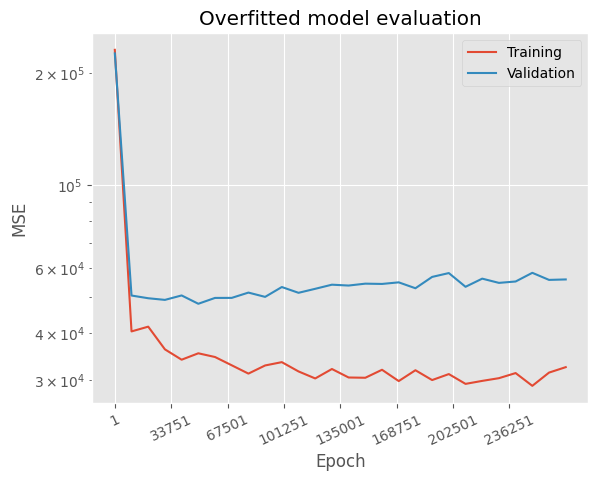

In [6]:
import matplotlib.pyplot as plt

train_losses_sampled = train_losses[::10000]  # Select every 1000th value
val_losses_sampled = val_losses[::10000]      # Select every 1000th value

# Generate corresponding epoch numbers, assuming epochs_suc is your list of epoch numbers
epochs_sampled = epochs_suc[::10000]

plt.style.use("ggplot")
plt.title("Overfitted model evaluation")


# Use sampled data for plotting
plt.plot(epochs_sampled, train_losses_sampled, label='Training')
plt.plot(epochs_sampled, val_losses_sampled, label='Validation')

plt.ylabel("MSE")
plt.xlabel("Epoch")
plt.yscale('log')
plt.xticks(
    range(1, epochs_sampled[-1], int(epochs_sampled[-1] / 8)),
    range(1, epochs_sampled[-1], int(epochs_sampled[-1] / 8)),
    rotation = 25
)
plt.legend()
plt.show()
# plt.savefig("../visualizations/overfit_model_evaluation_full_dataset.png", dpi=800)

# Saving. Good results

In [ ]:
# class TabularFFNNSimple(nn.Module):
#     def __init__(self, input_size, output_size, dropout_prob=0.4):
#         super(TabularFFNNSimple, self).__init__()
#         hidden_size = 48
#         self.ffnn = nn.Sequential(
#             nn.Linear(input_size, hidden_size),
#             nn.ReLU(),
# #             nn.BatchNorm1d(hidden_size),
# #             nn.Dropout(0.5),
#             nn.Linear(hidden_size, hidden_size),
#             nn.ReLU(),
# #             nn.Dropout(0.5),
#             nn.Linear(hidden_size, output_size)
#         )
        
#         for m in self.ffnn:
#             if isinstance(m, nn.Linear):
#                 init.xavier_uniform_(m.weight)
#                 m.bias.data.fill_(0)

#     def forward(self, x):
#         x = x.float()
#         # print(x)
#         x = x.view(x.size(0), -1)
#         x = self.ffnn(x)
#         return x
    
# # Split the data into features and target
# X = data.drop('price', axis=1)
# y = data['price']

# # Standardize the features
# device = torch.device("cpu")
# # Convert to PyTorch tensors
# X_tensor = torch.tensor(X.to_numpy(), dtype=torch.float32, device = device)
# y_tensor = torch.tensor(y.values, dtype=torch.float32, device = device)


# # Split the data into training and combined validation and testing sets
# X_train, X_val_test, y_train, y_val_test = train_test_split(X_tensor, y_tensor,
#                                                             test_size=0.4, random_state=42)

# # Split the combined validation and testing sets
# X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

# # Create DataLoader for training, validation, and testing
# train_data = TensorDataset(X_train, y_train)
# val_data = TensorDataset(X_val, y_val)
# test_data = TensorDataset(X_test, y_test)

# batch_size = 256
# train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
# val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
# test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# # Check if the dimensions match the expected input size for the model
# input_size = X_train.shape[1]

# # Output
# # input_size, train_loader, test_loader

# model = TabularFFNNSimple(
#     input_size = input_size,
#     output_size = 1
# )
# model.to(device)

# num_epochs = 300000
# train_losses = []
# val_losses = []
# epochs_suc = [] # to have a reference to it
# grad_norms = []

# def get_gradient_norm(model):
#     total_norm = 0
#     for p in model.parameters():
#         if p.grad is not None:
#             param_norm = p.grad.data.norm(2)
#             total_norm += param_norm.item() ** 2
#     total_norm = total_norm ** 0.5
#     return total_norm

# optimizer = optim.Adam(
#     model.parameters(), 
#     lr=9e-3,
#     weight_decay=1e-4
# )
# criterion = torch.nn.MSELoss()
# criterion_abs = torch.nn.L1Loss()
# criterion = criterion_abs

# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer, 
#     mode='min', 
#     factor=0.999999, 
#     patience=10, 
#     verbose=True
# )

# for epoch in range(num_epochs):
#     # Training
#     model.train()  # Set the model to training mode
#     running_loss = 0.0
#     l1_losses = []
#     grad_norm = 0
#     for tuple_ in train_loader:
#         datas, prices = tuple_
#         optimizer.zero_grad()
#         outputs = model(datas)
#         prices_viewed = prices.view(-1, 1).float()
#         loss = criterion(outputs, prices_viewed)
#         loss.backward()
#         grad_norm += get_gradient_norm(model)
#         optimizer.step()

#         running_loss += loss.item()
        
#     grad_norms.append(grad_norm / len(train_loader))
#     train_losses.append(running_loss / len(train_loader))  # Average loss for this epoch

#     # Validation
#     model.eval()  # Set the model to evaluation mode
#     val_loss = 0.0
#     with torch.no_grad():  # Disable gradient calculation
#         for tuple_ in val_loader:
#             datas, prices = tuple_
#             outputs = model(datas)  # Forward pass
#             prices_viewed = prices.view(-1, 1).float()
#             loss = criterion(outputs, prices_viewed)  # Compute loss
#             val_loss += loss.item()  # Accumulate the loss
#             l1_losses.append(criterion_abs(outputs, prices_viewed))

#     val_losses.append(val_loss / len(val_loader))  # Average loss for this epoch
#     l1_mean_loss = sum(l1_losses) / len(l1_losses)
#     # Print epoch's summary
#     epochs_suc.append(epoch)
#     scheduler.step(val_losses[-1])
#     if epoch % 100 == 0:
#         tl = f"Training Loss: {int(train_losses[-1])}"
#         vl = f"Validation Loss: {int(val_losses[-1])}"
#         l1 = f"L1: {int(l1_mean_loss)}"
#         dl = f'Epoch {epoch+1}, {tl}, {vl}, {grad_norms[-1]}'
#         print(dl)